In [1]:
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Misal $d_t$ adalah data pada waktu ke-$t$, dengan $1\leq t\leq n$  dan $w$ adalah  ukuran window. Kode di bawah akan menghasilkan dataset berupa himpunan $\mathbb{D}=\{(\mathbf{x}^{(k)},\mathbf{y}^{(k)})|\mathbf{x}^{(k)},\mathbf{y}^{(k)}\in \mathbb{R}^{w},k=1,\dots  ,n-w+1\}$ dimana $\mathbf{x}^{k}_{i}=d_{i+k-1}$ dan  $\mathbf{y}^{k}_{i}=d_{i+k}$.
Contoh, diberikan data 

|waktu         |   keuntungan | 
|---|---|
|april-2001    |   10|           
|mei-2001      |   43|
|juni-2001     |   76|
|juli-2001     |   89|
|agustus-2001  |   66|
|september-2001|   29|
|oktober-2001  |   16|
|november-2001 |   99|

Jika $w$ (window size) adalah $3$ maka data yang daset yang digenerate adalah
$[(10,43,76),(43,76,89)],[(43,76,89),(76,89,66)]$ dan seterusnya



In [2]:
class Pembaca_CSV(Dataset):
    def __init__(self, window_size, csv_path,column):
        df = pd.read_csv(csv_path)
        ys = np.array(df[column])
        self.nilai_maksimum= max(ys)
        #Normalisasi nilai Y
        self.ys = ys / self.nilai_maksimum
        self.window_size = window_size
    def __len__(self):
        return len(self.ys) - self.window_size
    def __getitem__(self, idx):
        data_x = self.ys[idx:idx + self.window_size].squeeze()
        data_y = self.ys[idx + self.window_size]
        return torch.tensor(data_x).to(torch.float), torch.tensor(data_y).to(torch.float)
    def hitung_maksimum(self):
        return self.nilai_maksimum

Implementasi GRU cell menggunakan module nn PyTorch 


In [3]:
class GRUCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        x = x.view(-1, x.size(1))

        gate_x = self.x2h(x)
        gate_h = self.h2h(hidden)

        if gate_x.shape[0] > 1:
            gate_x = gate_x.squeeze()
            gate_h = gate_h.squeeze()

        i_r, i_i, i_n = gate_x.chunk(3, 1)
        h_r, h_i, h_n = gate_h.chunk(3, 1)

        resetgate = torch.sigmoid(i_r + h_r)
        inputgate = torch.sigmoid(i_i + h_i)
        newgate = torch.tanh(i_n + (resetgate * h_n))

        hy = newgate + inputgate * (hidden - newgate)

        return hy


In [4]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(GRUModel, self).__init__()
        # Dimensi hidden layer
        self.hidden_dim = hidden_dim

        # Banyaknya Hidden layer
        self.layer_dim = layer_dim

        self.gru_cell = GRUCell(input_dim, hidden_dim, layer_dim)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):


        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        outs = []

        hn = h0[0, :, :]

        for seq in range(x.size(1)):
            hn = self.gru_cell(x[:, seq, :], hn)
            outs.append(hn)

        out = outs[-1].squeeze()

        out = self.fc(out)
        # out.size() --> 100, 10
        return out

In [5]:
batch_size = 100
n_iters = 1200
window_size = 60

#test_dataset hanya memiliki ukuran 1 batc
train_dataset = Pembaca_CSV(window_size,'train.csv','keuntungan')

test_dataset = Pembaca_CSV(window_size,'test.csv','keuntungan')

num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)



In [6]:
input_dim = 1
hidden_dim = 256
layer_dim = 1  
output_dim = 1
model = GRUModel(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters())
seq_dim = window_size

Mulai melatih jaringan saraf tiruan dengan algoritma optimasi adam dan fungsi error MSE



In [7]:
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt


def fit(num_epochs,  optimizer, test_loader, train_loader, model, criterion, input_dim, seq_dim):
    iter = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels.view(-1, 1))
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            # outputs.size() --> 100, 10
            images = images.to(torch.float)
            labels = labels.to(torch.float)

            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss

            loss = criterion(labels, outputs)
         

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            # loss_list.append(loss.item())
            iter += 1

            if iter % 500 == 0:

                total = 0
                for images, labels in test_loader:

                    images = Variable(images.view(-1, seq_dim, input_dim))

                    outputs = model(images)

                # Print Loss
                print('Iteration: {}. Loss: {}.'.format(iter, loss.item()))
    torch.save(model.state_dict(),"gru_weight.pt")


In [8]:
#fit(num_epochs, optimizer, test_loader, train_loader, model, criterion, input_dim, seq_dim)
model.load_state_dict(torch.load("gru_weight.pt"))
model = model.eval()


In [9]:
def multi_steps_forecasting(model, steps, input_data):
    input_data = input_data.unsqueeze(0).unsqueeze(-1)
    result = []
    for i in range(steps):
        o = model.forward(input_data)
        input_data = torch.cat((input_data[:, 1:, :], o.unsqueeze(0).unsqueeze(-1)), 1)
        result.append(o.squeeze().detach().numpy())
    return np.array(result)


def plot_multisteps_forecasting(scale,predictions, real_data,steps):
    real_data = real_data.squeeze().squeeze(-1)    
    real_data_size = len(real_data)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(scale * real_data, 'b',label="Data sebenarnya")
    ax.plot(np.arange(real_data_size - steps, real_data_size + len(predictions) - steps), scale * predictions, 'r--',label="Prediksi")
    ax.legend()
    plt.show()


Tampilkan hasil prediksi untuk 10 timestep ke depan

In [10]:
def multi_steps_forecasting(model, steps, input_data):
    input_data = input_data.unsqueeze(0).unsqueeze(-1)
    result = []
    for i in range(steps):
        o = model.forward(input_data)
        input_data = torch.cat((input_data[:, 1:, :], o.unsqueeze(0).unsqueeze(-1)), 1)
        result.append(o.squeeze().detach().numpy())
    return np.array(result)


def plot_multisteps_forecasting(predictions, real_data,steps):
    print(predictions)
    real_data = real_data.squeeze().squeeze(-1)    
    real_data_size = len(real_data)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(real_data, 'b',label="Data sebenarnya")
    ax.plot(real_data,)
    ax.plot(np.arange(real_data_size - steps, real_data_size + len(predictions) - steps),  predictions, 'r--',label="Prediksi")
    ax.legend()
    plt.show()


In [38]:
n_th_sample = 0
steps = 36
sample, true_prediction = test_dataset[n_th_sample]
data_sebenarnya, _ = test_dataset[n_th_sample + steps]
maksimum = test_dataset.hitung_maksimum()
hasil_prediksi = multi_steps_forecasting( model, steps, sample)

#Melakukan denormalisasi data
hasil_prediksi = maksimum * hasil_prediksi
data_sebenarnya = maksimum * data_sebenarnya

for f,a in zip(hasil_prediksi,data_sebenarnya):
    print("Hasil_prediksi : {} data_sebenarnya : {}".format(f,a))



Hasil_prediksi : 140.63424682617188 data_sebenarnya : 152.90000915527344
Hasil_prediksi : 138.59014892578125 data_sebenarnya : 135.50001525878906
Hasil_prediksi : 140.31918334960938 data_sebenarnya : 148.5
Hasil_prediksi : 143.1083221435547 data_sebenarnya : 148.40000915527344
Hasil_prediksi : 152.80003356933594 data_sebenarnya : 133.59999084472656
Hasil_prediksi : 167.23248291015625 data_sebenarnya : 194.10000610351562
Hasil_prediksi : 182.66464233398438 data_sebenarnya : 208.60000610351562
Hasil_prediksi : 182.1256866455078 data_sebenarnya : 197.3000030517578
Hasil_prediksi : 147.80584716796875 data_sebenarnya : 164.39999389648438
Hasil_prediksi : 150.55662536621094 data_sebenarnya : 148.09999084472656
Hasil_prediksi : 157.15902709960938 data_sebenarnya : 152.0
Hasil_prediksi : 146.99636840820312 data_sebenarnya : 144.10000610351562
Hasil_prediksi : 140.4568634033203 data_sebenarnya : 155.0
Hasil_prediksi : 137.41659545898438 data_sebenarnya : 124.5
Hasil_prediksi : 138.6843414306640

Plot terhadap data baru

[140.63425 138.59015 140.31918 143.10832 152.80003 167.23248 182.66464
 182.12569 147.80585 150.55663 157.15903 146.99637 140.45686 137.4166
 138.68434 143.22243 152.60117 170.67525 185.22334 176.99533 145.97198
 151.65857 161.73448 147.8172  143.35347 138.57039 140.2744  147.00679
 156.63362 174.74014 186.11404 170.65353 149.60896 157.78938 164.56136
 152.62971]


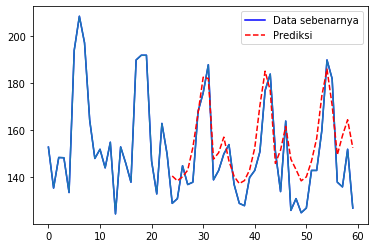

In [39]:
plot_multisteps_forecasting(hasil_prediksi, data_sebenarnya,steps)

In [40]:
def hitung_mape(data_sebenarnya,hasil_prediksi):
    #banyaknya data
    n = len(hasil_prediksi)
    tot = 0.0
    for t in range(n):
        At = data_sebenarnya[t]
        Ft = hasil_prediksi[t]
        tot +=np.abs((At-Ft)/At)
    return ((100.0/float(n))*tot).numpy()    
        

In [43]:
hasil = hitung_mape(data_sebenarnya,hasil_prediksi)
print("Melakukan prediksi sebanyak langkah {} kedepan menghasilkan MAPE {} % ".format(steps,hasil))

Melakukan prediksi sebanyak langkah 36 kedepan menghasilkan MAPE 7.040910243988037 % 
